In [1]:
import os
import re
import gc
import multiprocessing

import dlib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import distance

In [38]:
a = []
np.clip(a, a_min=None, a_max=4).astype(np.int32)

array([], dtype=int32)

In [64]:
#! /usr/bin/env python
import os
import cv2
import json
import argparse
import numpy as np
import scipy.spatial as spatial

## 3D Transform
def bilinear_interpolate(img, coords):
    """ Interpolates over every image channel
    http://en.wikipedia.org/wiki/Bilinear_interpolation
    :param img: max 3 channel image
    :param coords: 2 x _m_ array. 1st row = xcoords, 2nd row = ycoords
    :returns: array of interpolated pixels with same shape as coords
    """
    int_coords = np.int32(coords)
    x0, y0 = int_coords
    dx, dy = coords - int_coords
    
    x0 = np.clip(x0, a_min=None, a_max=img.shape[1]-2).astype(np.int32)
    y0 = np.clip(y0, a_min=None, a_max=img.shape[0]-2).astype(np.int32)

    # 4 Neighour pixels
    q11 = img[y0, x0]
    q21 = img[y0, x0 + 1]
    q12 = img[y0 + 1, x0]
    q22 = img[y0 + 1, x0 + 1]

    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    inter_pixel = top * dy + btm * (1 - dy)

    return inter_pixel.T

def grid_coordinates(points):
    """ x,y grid coordinates within the ROI of supplied points
    :param points: points to generate grid coordinates
    :returns: array of (x, y) coordinates
    """
    xmin = np.min(points[:, 0])
    xmax = np.max(points[:, 0]) + 1
    ymin = np.min(points[:, 1])
    ymax = np.max(points[:, 1]) + 1
    return np.asarray([(x, y) for y in range(ymin, ymax)
                       for x in range(xmin, xmax)], np.uint32)

def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    """
    Warp each triangle from the src_image only within the
    ROI of the destination image (points in dst_points).
    """
    roi_coords = grid_coordinates(dst_points)
    # indices to vertices. -1 if pixel is not in any triangle
    roi_tri_indices = delaunay.find_simplex(roi_coords)

    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index],
                            np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        
        x = np.clip(x, a_min=None, a_max=img.shape[1]-1).astype(np.int32)
        y = np.clip(y, a_min=None, a_max=img.shape[0]-1).astype(np.int32)
        
        result_img[y, x] = bilinear_interpolate(src_img, out_coords)

    return None

def triangular_affine_matrices(vertices, src_points, dst_points):
    """
    Calculate the affine transformation matrix for each
    triangle (x,y) vertex from dst_points to src_points
    :param vertices: array of triplet indices to corners of triangle
    :param src_points: array of [x, y] points to landmarks for source image
    :param dst_points: array of [x, y] points to landmarks for destination image
    :returns: 2 x 3 affine matrix transformation for a triangle
    """
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dst_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat

def warp_image_3d(src_img, src_points, dst_points, dst_shape, dtype=np.uint8):
    rows, cols = dst_shape[:2]
    result_img = np.zeros((rows, cols, 3), dtype=dtype)

    delaunay = spatial.Delaunay(dst_points)
    tri_affines = np.asarray(list(triangular_affine_matrices(
        delaunay.simplices, src_points, dst_points)))

    process_warp(src_img, result_img, tri_affines, dst_points, delaunay)

    return result_img

## 2D Transform
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(np.dot(points1.T, points2))
    R = (np.dot(U, Vt)).T

    return np.vstack([np.hstack([s2 / s1 * R,
                                (c2.T - np.dot(s2 / s1 * R, c1.T))[:, np.newaxis]]),
                      np.array([[0., 0., 1.]])])

def warp_image_2d(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

## Generate Mask
def mask_from_points(size, points, radius=2):
    # radius == kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    mask = cv2.erode(mask, kernel)

    return mask

## Color Correction
def correct_colours(im1, im2, landmarks1):
    COLOUR_CORRECT_BLUR_FRAC = 0.75
    LEFT_EYE_POINTS = list(range(42, 48))
    RIGHT_EYE_POINTS = list(range(36, 42))

    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur = im2_blur.astype(int)
    im2_blur += 128*(im2_blur <= 1)

    result = im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64)
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

## Copy-and-paste
def apply_mask(img, mask):
    """ Apply mask to supplied image
    :param img: max 3 channel image
    :param mask: [0-255] values in mask
    :returns: new image with mask applied
    """
    masked_img = np.copy(img)
    num_channels = 3
    for c in range(num_channels):
        masked_img[..., c] = img[..., c] * (mask / 255)

    return masked_img

## Alpha blending
def alpha_feathering(src_img, dest_img, img_mask, blur_radius=15):
    mask = cv2.blur(img_mask, (blur_radius, blur_radius))
    mask = mask / 255.0

    result_img = np.empty(src_img.shape, np.uint8)
    for i in range(3):
        result_img[..., i] = src_img[..., i] * mask + dest_img[..., i] * (1-mask)

    return result_img

### TO DO:   
##### BACK:
 - *preprocess_img* is a bottleneck -- faces comparison must be in parallel processes!  
 - build docker  
 - download images and make a mix in one request  
 - add log file  

##### FRONT:  
 - shaded answer 
 - make possible to select people on selfies  
 - exceptions when no faces found / no faces selected but at least one found on both photos  

In [3]:
path = "./data"

In [4]:
def show_img(img, figsize=(7, 14)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()
    
def crop_face(img, bboxs, offset=10):
    imgs = []
    for bbox in bboxs:
        x = bbox[0] 
        y = bbox[1]
        w = bbox[2] - x
        h = bbox[3] - y

        x = max(x - offset//2, 0)
        y = max(y - offset//2, 0)
        w = min(img.shape[0], w + offset)
        h = min(img.shape[1], h + offset)
        imgs.append(img[y:y+h, x:x+w])
    return imgs

In [5]:
def open_img(name, biggest=400):
    img = cv2.imread(os.path.join(path, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scale = biggest / max(img.shape[:-1]) 
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

def face_detection(img):
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detector = dlib.get_frontal_face_detector()
    faces = detector(img, 1)
    bboxs = []

    for face in faces:
        bboxs.append((face.left(), face.top(), face.right(), face.bottom()))
    
    return bboxs

def face_points_detection(img, bbox):
    # Get the landmarks/parts for the face in box d.
    shape = predictor(img, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    coords = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

    # return the list of (x, y)-coordinates
    return coords

def select_faces(im, bbox, r=10):
    points = face_points_detection(im, dlib.rectangle(*bbox))
    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)
    
    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def calc_dist(img0, img1):
    return distance.euclidean(img0, img1)

def insert_face():
    
    result = preprocess_img.run()
    if result is None:
        return None
    
    result_bboxs = []
    for faces in result:
        dst_points, dst_shape, dst_face = faces[0]
        src_points, src_shape, src_face = faces[1]

        warp_2d = False
        correct_color = True
        max_points = 58

        w, h = dst_face.shape[:2]

        ### Warp Image
        if not warp_2d:
            ## 3d warp
            warped_src_face = warp_image_3d(src_face, src_points[:max_points], dst_points[:max_points], (w, h))
        else:
            ## 2d warp
            src_mask = mask_from_points(src_face.shape[:2], src_points, radius=2)
            src_face = apply_mask(src_face, src_mask)
            # Correct Color for 2d warp
            if correct_color:
                warped_dst_img = warp_image_3d(dst_face, dst_points[:max_points], 
                                               src_points[:max_points], src_face.shape[:2])
                src_face = correct_colours(warped_dst_img, src_face, src_points)
            # Warp
            warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (w, h, 3))

        ## Mask for blending
        mask = mask_from_points((w, h), dst_points, radius=2)
        mask_src = np.mean(warped_src_face, axis=2) > 0
        mask = np.asarray(mask*mask_src, dtype=np.uint8)

        ## Correct color
        if not warp_2d and correct_color:
            warped_src_face = apply_mask(warped_src_face, mask)
            dst_face_masked = apply_mask(dst_face, mask)
            warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)

        ##Poisson Blending
        r = cv2.boundingRect(mask)
        center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
        output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

        x, y, w, h = dst_shape
        result_bboxs.append(dst_shape)
        
        #dst_img_cp = CROWD.copy()
        CROWD[y:y+h, x:x+w] = output
        #output = dst_img_cp
        

    output_labeled = CROWD.copy()
    for bbox in result_bboxs:
        x, y, w, h = bbox
        cv2.rectangle(output_labeled, (x, y), (x+w, y+h), (255,0,0), 2)
    
    return output_labeled

In [6]:
def chunker(l, n):
    length = len(l)
    n = length // n
    for i in range(0, length, n):
        if length - i < 2*n:
            yield l[i:]
            break
        else:
            yield l[i:i + n]

class preprocess_img:

    @classmethod
    def run(self, max_dst_boxes=15, embeddings_max_iters=2, n_jobs=2, *args):
        
        self.embeddings_max_iters = embeddings_max_iters
        my_bboxs = np.array(face_detection(ME))
        
        # args is points on the faces to be swapped (selfies / friends photos)
        if args:
            to_keep = []
            for arg in args:
                for j, bbox in enumerate(my_bboxs):
                    if (bbox[0] <= arg[0] <= bbox[2]) and \
                       (bbox[1] <= arg[1] <= bbox[3]):
                            to_keep.append(j)
            my_bboxs = my_bboxs[to_keep]

        self.bboxs = np.array(face_detection(CROWD))
        if len(self.bboxs) == 0 or len(my_bboxs) == 0:
            return None

        random_sample_bboxs = np.random.choice(list(range(len(self.bboxs))), 
                                               size=min(len(self.bboxs), max_dst_boxes))
        random_sample_my_bboxs = np.random.choice(list(range(len(my_bboxs))), 
                                               size=min(len(my_bboxs), max_dst_boxes))

        if len(random_sample_bboxs) < len(self.bboxs):
            self.bboxs = self.bboxs[random_sample_bboxs]

        if len(random_sample_my_bboxs) < len(my_bboxs):
            my_bboxs = my_bboxs[random_sample_my_bboxs]

        if len(self.bboxs) < 2:
            n_jobs = 1
            
        out, self.ignore_list = [], []
        for i in range(len(my_bboxs)):
            self.src_face_descriptor = facerec.compute_face_descriptor(ME, 
                                  sp(ME, dlib.rectangle(*my_bboxs[i])), embeddings_max_iters)

            if n_jobs == 1:
                dsts = np.full(len(bboxs), np.inf)
                for j, bbox in enumerate(bboxs):
                    if j in ignore_list:
                        continue
                    face_descriptor = facerec.compute_face_descriptor(CROWD,
                                      sp(CROWD, dlib.rectangle(*bbox)), embeddings_max_iters)
                    dsts[j] = calc_dist(src_face_descriptor, face_descriptor)
            else:
                manager = multiprocessing.Manager()
                pool = multiprocessing.Pool(n_jobs)
                res = manager.list([0] * n_jobs)
                chunks = list(chunker(list(range(len(self.bboxs))), n_jobs))
                pool.map(self.run_comparison, [(j, chunks[j], res) for j in range(n_jobs)])
                dsts = np.concatenate([res[j] for j in range(n_jobs)], axis=0)
                pool.close()
                gc.collect()

            #clst = np.random.choice(np.argsort(dsts)[:2])
            clst = np.argmin(dsts)
            self.ignore_list.append(clst)
            out.append((select_faces(CROWD, self.bboxs[clst]), select_faces(ME, my_bboxs[i])))
        return out
    
    @classmethod
    def run_comparison(self, args):
        k, chunk, res = args
        dsts = np.full(len(chunk), np.inf)
        for l, m in enumerate(chunk):
            if m in self.ignore_list:
                continue
            face_descriptor = facerec.compute_face_descriptor(CROWD,
                              sp(CROWD, dlib.rectangle(*self.bboxs[m])), self.embeddings_max_iters)
            dsts[l] = calc_dist(self.src_face_descriptor, face_descriptor)
        res[k] = dsts
        del dsts; gc.collect()

In [7]:
# face landmarks
predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

# dlib facerecognition
sp = dlib.shape_predictor("./models/shape_predictor_5_face_landmarks.dat")
facerec = dlib.face_recognition_model_v1("./models/dlib_face_recognition_resnet_model_v1.dat")

In [104]:
%%time

#ME = open_img("you_2.jpg", biggest=400)
ME = open_img("you_main.jpg", biggest=400)
#ME = open_img("trump_3.png", biggest=max_side)

CROWD = open_img("playboy.png", biggest=800)
#CROWD = open_img("trump.png", biggest=1200)
#CROWD = open_img("kim.jpg", biggest=1200)

CPU times: user 184 ms, sys: 36 ms, total: 220 ms
Wall time: 147 ms


python main.py --src imgs/test6.jpg --dst imgs/test7.jpg --out results/output6_7_2d.jpg --correct_color --warp_2d

In [64]:
%%time

output_labeled = insert_face()

CPU times: user 912 ms, sys: 160 ms, total: 1.07 s
Wall time: 1.54 s


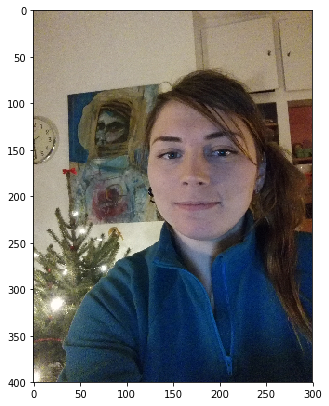

In [106]:
show_img(ME, figsize=(5, 10))

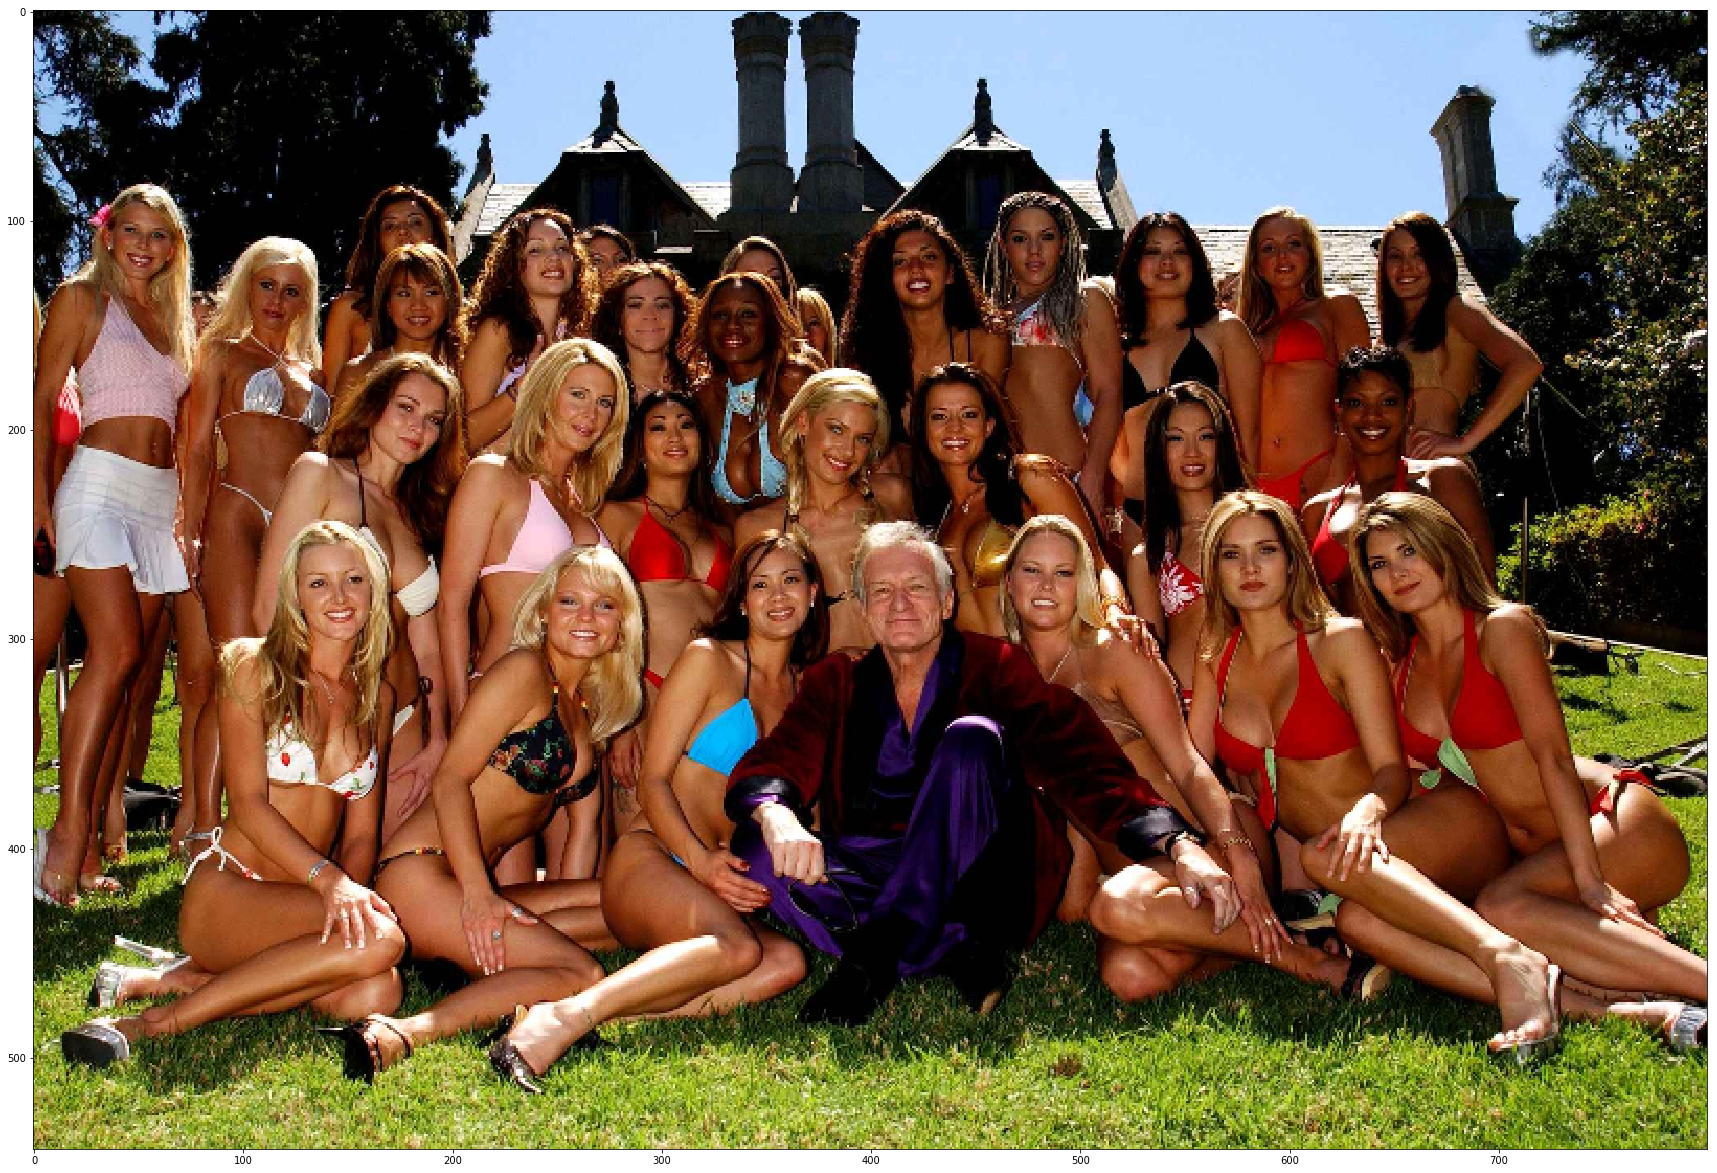

In [17]:
show_img(CROWD, figsize=(30, 60))

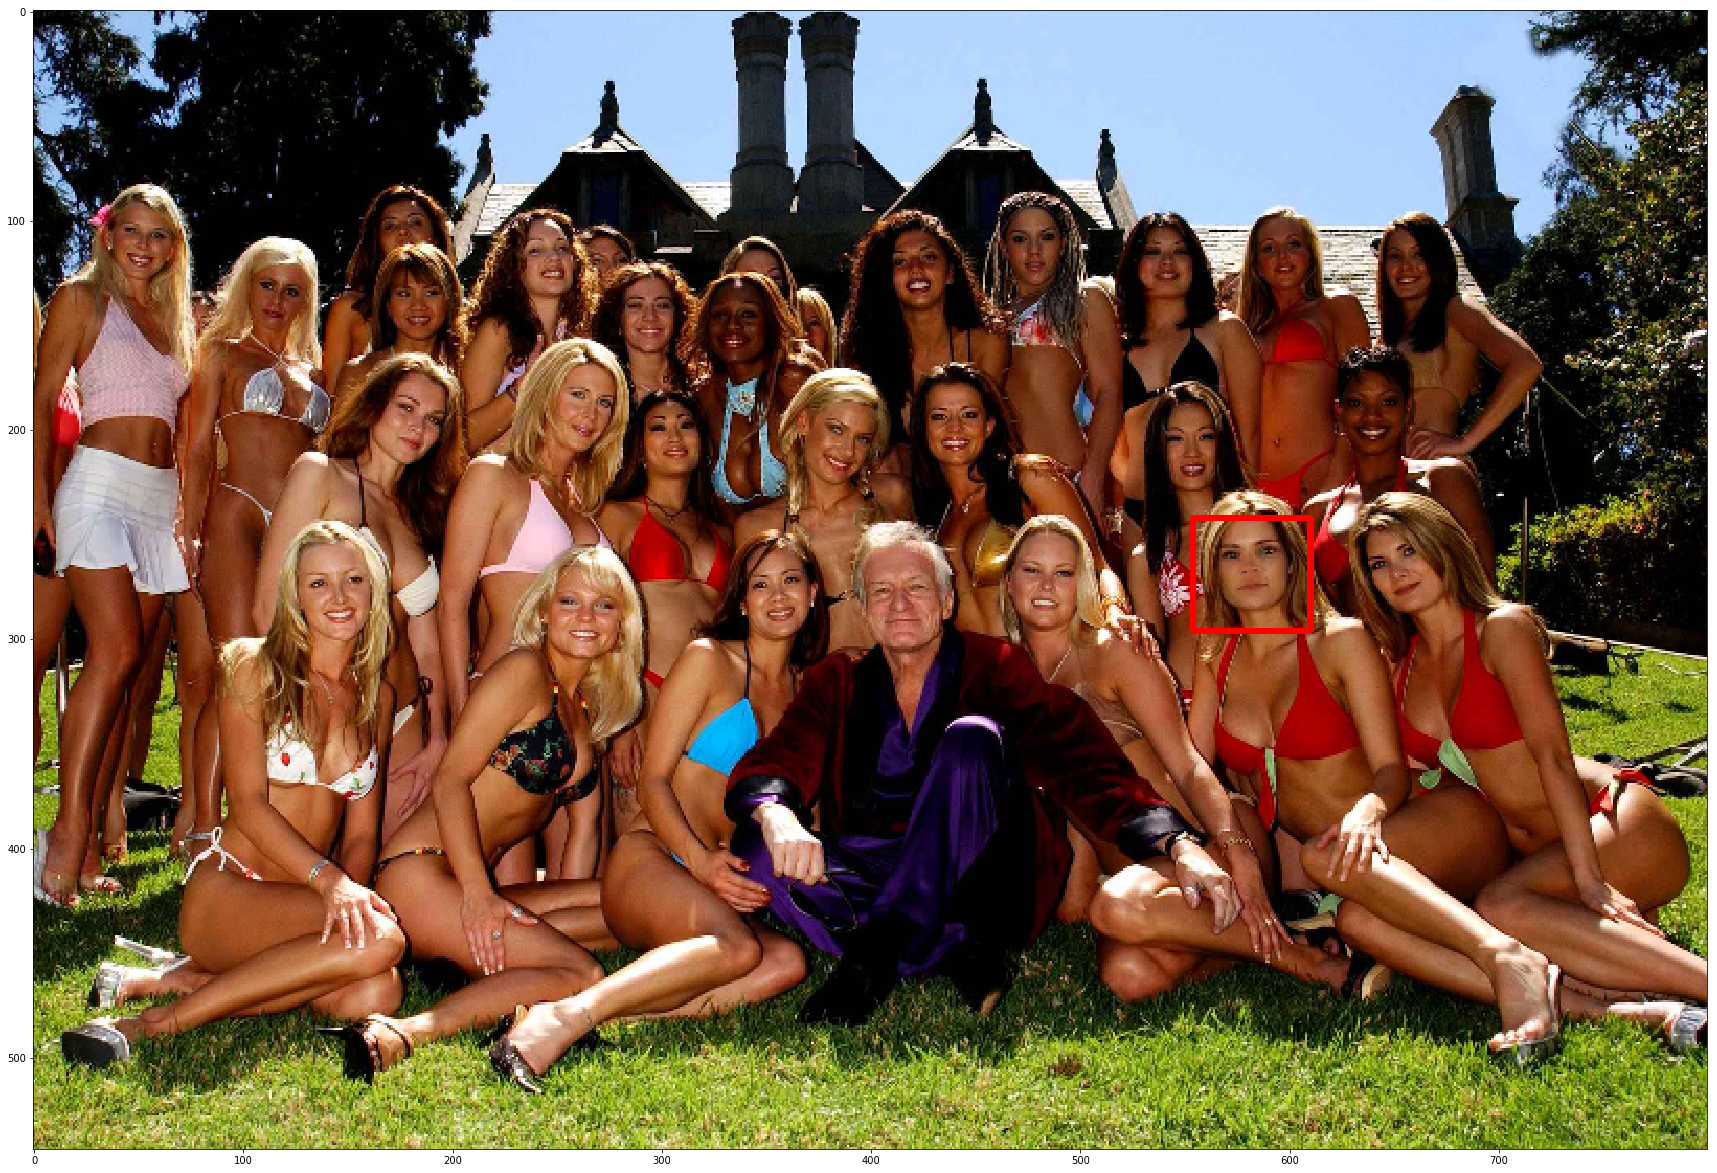

In [66]:
show_img(output_labeled, figsize=(30, 60))

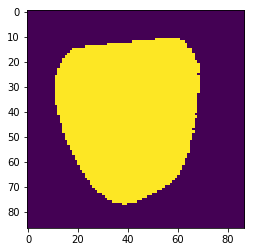

In [75]:
plt.imshow(mask)

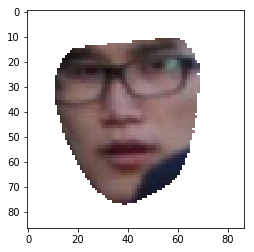

In [76]:
plt.imshow(np.concatenate([dst_face, mask[:, :, np.newaxis]], axis=2))

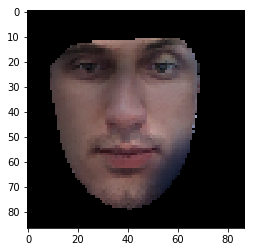

In [77]:
plt.imshow(warped_src_face)

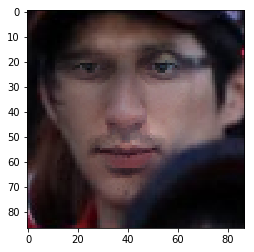

In [78]:
plt.imshow(new_output)

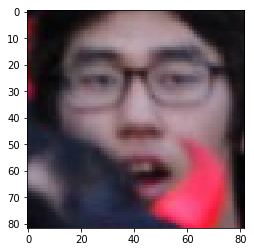

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

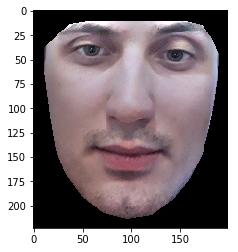

In [23]:
plt.imshow(src_face)

In [35]:
points = face_detection(me)[0]
me_cropped = me[points[1]:points[3], points[0]:points[2]]

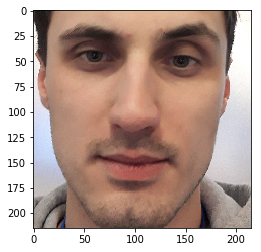

In [79]:
plt.imshow(me_cropped)
plt.show()

In [37]:
cv2.imwrite("./data/me_cropped.jpg", me_cropped)

True

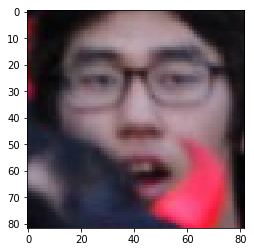

In [173]:
n = 7

plt.imshow(crops[n])
plt.show()

In [8]:
from PIL import Image
import requests
import urllib
from io import BytesIO
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [9]:
import json

In [10]:
url = "https://gdb.rferl.org/1C35D0C4-8304-4E8F-8A7A-594CA1184A00_cx13_cy37_cw68_w1597_n_r1_s.jpg"
#url = "https://kwtri4b8r0ep8ho61118ipob-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/30618448036_d9489f3630_k.jpg"

In [48]:
me = "http://temp-images.ws.pho.to/4bc954c858c45580bf83f7808ab69d88828e5d23.png"
friend = "http://temp-images.ws.pho.to/a511093dd9b54a61add093be27f56e22bc2f9225.jpeg"
crowd = "https://i.pinimg.com/originals/d0/9d/58/d09d58e44380014b6beef9eeacfe507f.jpg"

In [49]:
response = requests.get(me)
img = Image.open(BytesIO(response.content))
img = np.array(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

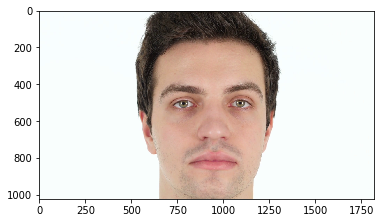

In [50]:
plt.imshow(img)
plt.show()

In [10]:
def open_from_url(url, biggest=400):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scale = biggest / max(img.shape[:-1]) 
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

In [61]:
retval, buff = cv2.imencode('.png', img)

In [62]:
buff

array([[137],
       [ 80],
       [ 78],
       ...,
       [ 66],
       [ 96],
       [130]], dtype=uint8)

In [9]:
import boto3
import random
import os

In [10]:
os.environ['AWS_PROFILE'] = "photo-hack-gene"

In [9]:
bucket_name = "storage.ws.pho.to"
path = "photohack/gene"

In [10]:
name = "test1"
#name = str(random.randint(0, 10e12))

In [11]:
#works
s3 = boto3.client('s3')
s3.upload_fileobj(BytesIO(buff), bucket_name, path+"/"+name+".jpeg", 
                  ExtraArgs={"ACL":'public-read', "StorageClass":'STANDARD'})

In [13]:
f = BytesIO()
s3.download_fileobj(
    bucket_name, path+"/"+name+".jpeg", f
)

NameError: name 's3' is not defined

In [112]:
img = Image.open(f)
img = np.array(img)

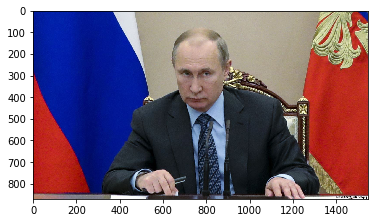

In [113]:
plt.imshow(img)
plt.show()

In [12]:
url = "https://storage.ws.pho.to/" + path+"/"+name+".jpeg"

In [13]:
url

'https://storage.ws.pho.to/photohack/gene/test1.jpeg'

In [15]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)

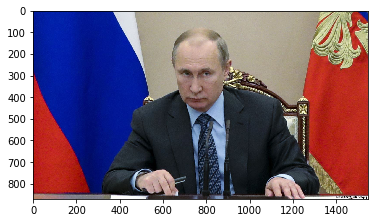

In [16]:
plt.imshow(img)

In [65]:
ME = open_from_url(me, biggest=400)
#ME = open_from_url(friend, biggest=400)
CROWD = open_from_url(crowd, biggest=1200)

In [66]:
%%time

output_labeled = insert_face()

[16 17 18 18 18 19 19 19 19 20 20 20 20 20 21 21 21 21 22 22 22 23 23] [16 16 15 16 17 15 16 17 18 15 16 17 18 19 17 18 19 20 19 20 21 21 22]
[41 42 42 42 43 43 43 43 43 44 44 44 44 44 44 45 45 45 45 45 45 45 46 46
 46 46 46 46 46 46 46 47 47 47 47 47 47 47 47 47 47 47 48 48 48 48 48 48
 48 48 48 48 48 48 49 49 49 49 49 49 49 49 49 49 49 49 49 49 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50] [33 31 32 33 29 30 31 32 33 27 28 29 30 31 32 26 27 28 29 30 31 32 24 25
 26 27 28 29 30 31 32 22 23 24 25 26 27 28 29 30 31 32 20 21 22 23 24 25
 26 27 28 29 30 31 18 19 20 21 22 23 24 25 26 27 28 29 30 31 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31]
[46 46 46 46 46 46 46 46 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47
 47 48 48 48 48 48 48 48 48 48 48 48 48 48 48 49 49 49 49 49 49 49 49 49
 49 50 50 50 50 50 50 50 51 51 51 51] [60 61 62 63 64 65 66 67 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 54 55 56 57 58 59 60 61 62 63 64 65 66 67 57 58 59 60 61 62 63 64 65
 66 60 61 62 63 64 6

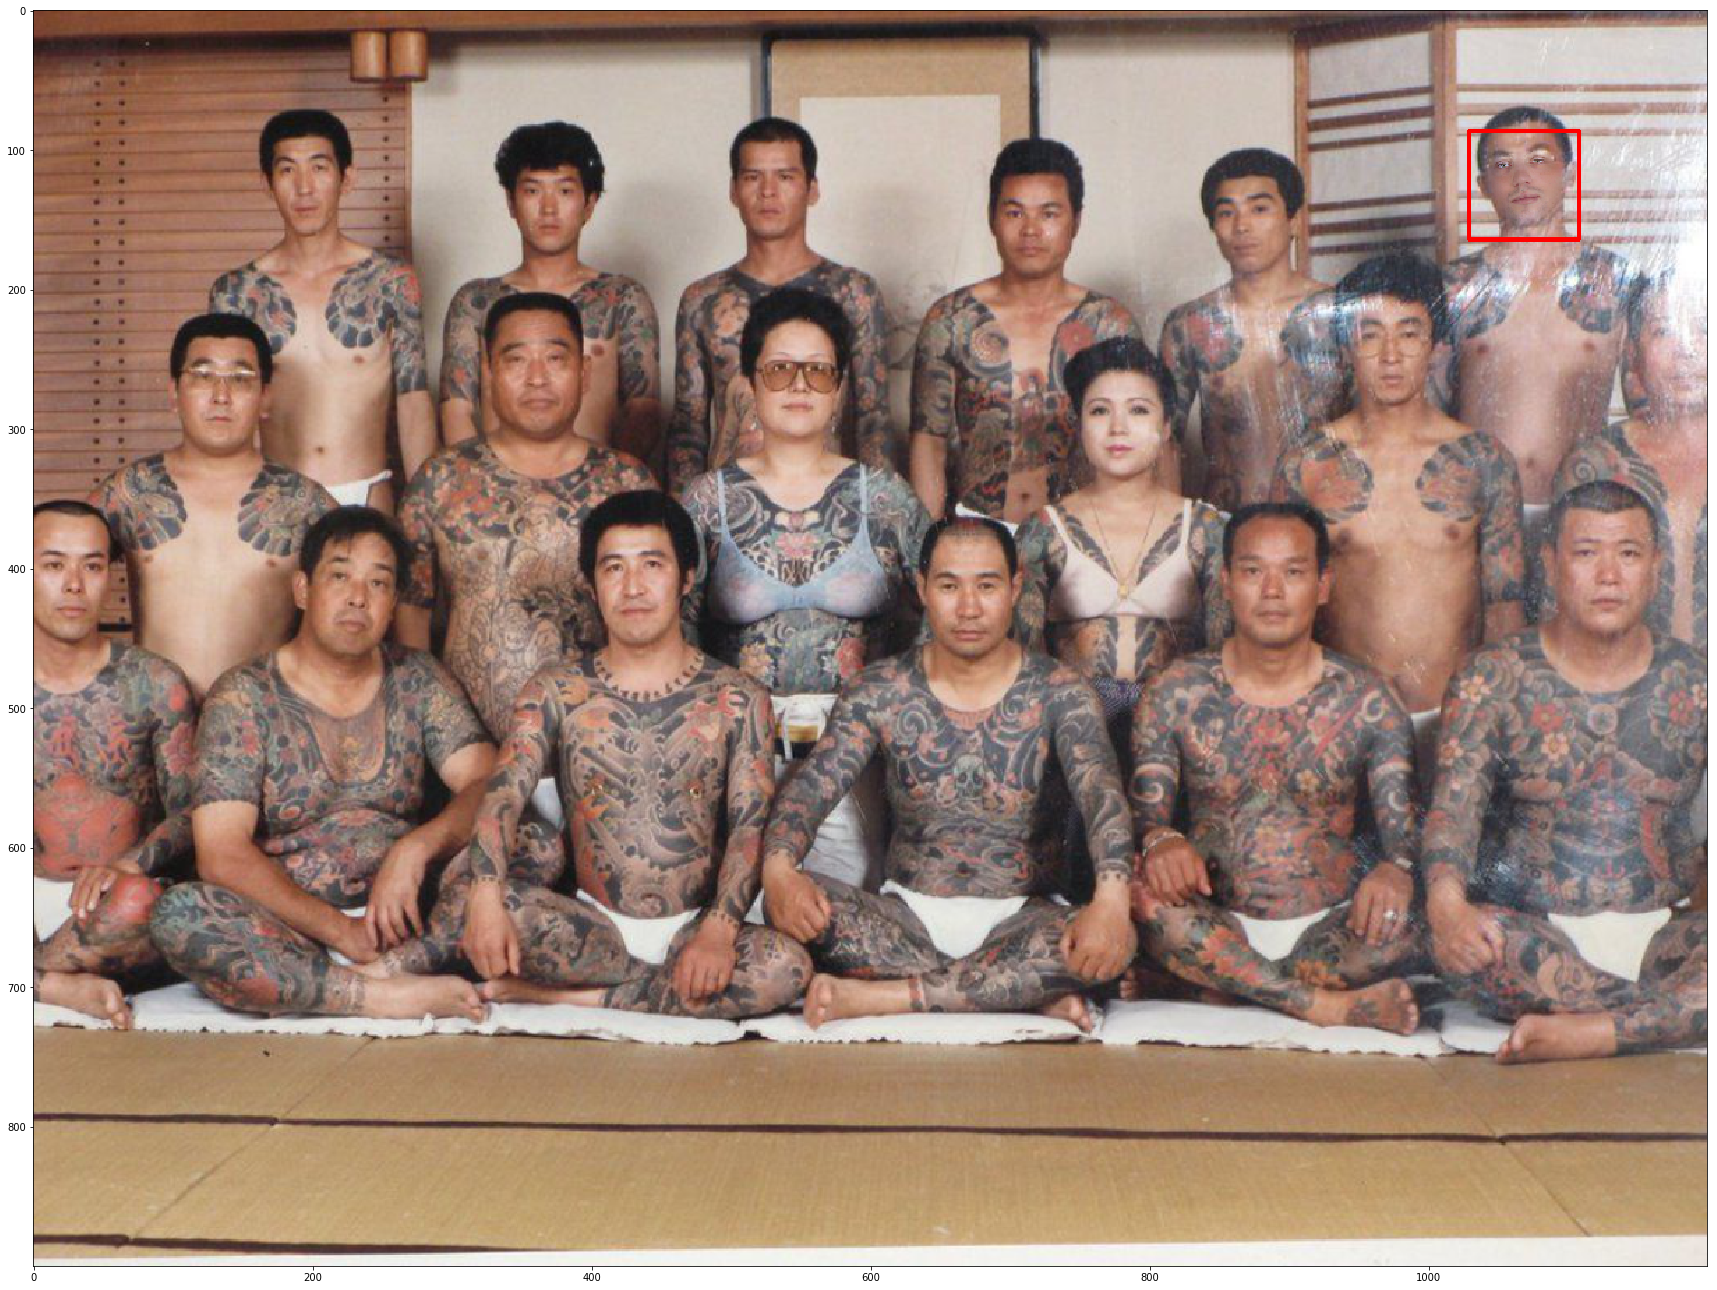

In [47]:
show_img(output_labeled, figsize=(30, 60))